# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

In [2]:
data = pd.read_csv('/content/ALL_FAIL_LOG_IMU_0_Add_Random.csv')

# Preprocessing and EDA

In [3]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (21597, 17)

Columns:
 Index(['LineNo', 'abTimeUS', 'abI', 'abGyrX', 'abGyrY', 'abGyrZ', 'abAccX',
       'abAccY', 'abAccZ', 'abEG', 'abEA', 'abT', 'abGH', 'abAH', 'abGHz',
       'abAHz', 'labels'],
      dtype='object')

Sample Data:
    LineNo   abTimeUS  abI    abGyrX    abGyrY     abGyrZ    abAccX    abAccY  \
0   14707   47623443    0  0.000652  0.000699   0.000664 -0.001625 -0.000529   
1  294758  359383689    0  3.323413 -5.883018  -6.913023  0.528758 -1.198488   
2  288150  352023301    0  4.783490 -6.518798 -28.446280 -0.080333 -0.054142   
3  265078  326383561    0  1.152616 -2.402375  -0.117582 -0.328573  0.036870   
4  105572  148903748    0  1.405822 -2.136524   0.033208 -5.092781 -0.064265   

      abAccZ  abEG  abEA       abT  abGH  abAH  abGHz  abAHz  labels  
0  -9.817689     0     0  27.83643     1     1   1000   1000       0  
1  -6.869982     0     0  38.92860     1     1    999    999       3  
2  -8.466424     0     0  38.77781     1     1    999

In [4]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo        int64
abTimeUS      int64
abI           int64
abGyrX      float64
abGyrY      float64
abGyrZ      float64
abAccX      float64
abAccY      float64
abAccZ      float64
abEG          int64
abEA          int64
abT         float64
abGH          int64
abAH          int64
abGHz         int64
abAHz         int64
labels        int64
dtype: object


labels
0    10147
4     3440
2     3092
1     2846
3     2072
Name: count, dtype: int64


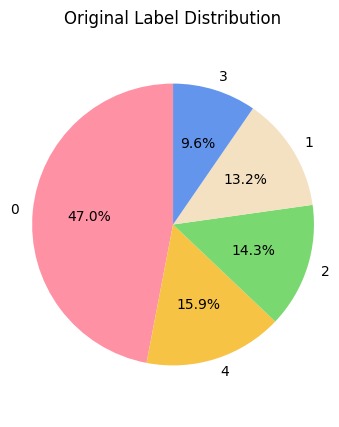

In [5]:
if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    print(label_counts)
    # Define specific colors for 5 labels
    colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]
    # Plot the pie chart
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.axis('equal')
    plt.title('Original Label Distribution')
    plt.show()

In [6]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [7]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [8]:
X.shape

(21597, 16)

In [9]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [11]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [12]:
X_reshaped.shape

(21597, 1, 16)

In [13]:
X_reshaped.shape[1]

1

In [14]:
X_reshaped.shape[2]

16

In [15]:
X_reshaped.shape[0]

21597

# **Model**

In [16]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [17]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [18]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    # inputs = Input(shape=input_shape)
    inputs = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [19]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [20]:
print(input_shape)

(1, 16)


In [21]:
print(num_classes)

5


In [22]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(X_reshaped, num_classes)
    # model= build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1

model.summary()


Training fold 1...
Validation Accuracy for fold 1: 0.9623
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 2...
Validation Accuracy for fold 2: 0.9780
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 3...
Validation Accuracy for fold 3: 0.9636
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Training fold 4...
Validation Accuracy for fold 4: 0.9699
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Training fold 5...
Validation Accuracy for fold 5: 0.9588
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 1, 64)               │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,705 (385.57 KB)

 Trainable params: 32,773 (128.02 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 65,548 (256.05 KB)

In [23]:
# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")


Average Accuracy across all folds: 0.9665


In [24]:
# Average accuracy per label
label_accuracies = np.mean(label_accuracies, axis=0)
for idx, acc in enumerate(label_accuracies):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9644
Label 1 Accuracy: 0.9859
Label 2 Accuracy: 0.9510
Label 3 Accuracy: 0.9480
Label 4 Accuracy: 0.9816


In [25]:
# Evaluate the last fold predictions
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_fold, axis=1)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9467    0.9656    0.9561      2006
           1     0.9848    0.9647    0.9747       539
           2     0.9226    0.8917    0.9069       628
           3     0.9871    0.9599    0.9733       399
           4     0.9880    0.9920    0.9900       747

    accuracy                         0.9588      4319
   macro avg     0.9659    0.9548    0.9602      4319
weighted avg     0.9588    0.9588    0.9587      4319



135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0    2046
4     750
2     607
1     528
3     388
Name: count, dtype: int64


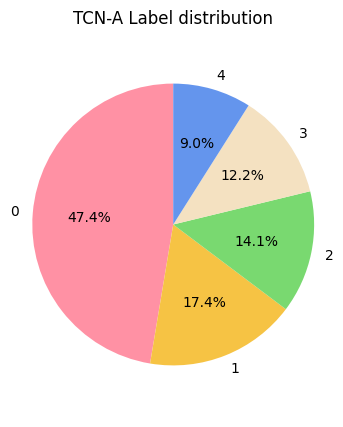

In [27]:
# Get the label distribution after training
# Get the predicted labels after training (from the last fold or the final model)
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

# Plot pie chart of predicted labels
plt.figure(figsize=(4, 5))
plt.pie(pd.Series(y_pred_classes).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90,colors=colors)
plt.axis('equal')
plt.title('TCN-A Label distribution')
plt.show()

In [28]:
import pandas as pd
import numpy as np

feature_names=["LineNo", "abTimeUS", "abI", "abGyrX", "abGyrY", "abGyrZ", "abAccX",
       "abAccY", "abAccZ", "abEG", "abEA", "abT", "abGH", "abAH", "abGHz",
       "abAHz"]

# Step 1: Get Model Predictions
y_pred_probs = model.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Filter only misclassified samples
mismatch_indices = y_true_labels != y_pred_labels  # Boolean mask for incorrect predictions

# Step 3: Print only misclassified rows
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]))  # Flatten features
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

print(df_mismatches)  # Print all misclassified cases




675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
            0         1    2         3         4         5         6  \
0    0.347019  0.258871  0.0  0.949216 -0.930962  0.427366  0.930460   
1    0.312942  0.224814  0.0 -1.660741 -0.202331  0.026130  0.930460   
2   -1.084055 -1.183508  0.0 -0.152129  1.640314  0.095197 -0.171389   
3    0.362496  0.274519  0.0 -1.509311  0.245428  0.583576  0.930460   
4   -0.636689 -0.729411  0.0  0.551573  1.708417  0.318172 -1.190890   
..        ...       ...  ...       ...       ...       ...       ...   
801  0.129051  0.266232  0.0 -0.932341  1.132881  0.012012  0.930460   
802 -0.350949 -0.216401  0.0  0.388118 -1.093539  0.070450  0.930460   
803  0.154184  0.291394  0.0 -0.700948  1.099680  0.154768  0.930460   
804 -1.104632 -0.976708  0.0 -0.264010 -1.228141  0.083410  0.289339   
805 -0.659684 -0.526598  0.0 -0.112880  1.499945  0.060603 -1.599939   

            7         8    9   10        11   12   13        14        15  \
0    1.030580  2.

In [29]:
import pandas as pd
import numpy as np

feature_names=["LineNo", "abTimeUS", "abI", "abGyrX", "abGyrY", "abGyrZ", "abAccX",
       "abAccY", "abAccZ", "abEG", "abEA", "abT", "abGH", "abAH", "abGHz",
       "abAHz"]

# Step 1: Get Model Predictions
y_pred_probs = model.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Identify misclassified samples and their indices
mismatch_indices = np.where(y_true_labels != y_pred_labels)[0]  # Get actual indices

# Step 3: Create DataFrame of misclassified samples with indices
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_mismatches['Index'] = mismatch_indices  # Add original index
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# Print misclassified samples with their original indices
print(df_mismatches[['Index', 'Actual_Label', 'Predicted_Label'] + feature_names])


675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
     Index  Actual_Label  Predicted_Label    LineNo  abTimeUS  abI    abGyrX  \
0       49             2                0  0.347019  0.258871  0.0  0.949216   
1       59             2                0  0.312942  0.224814  0.0 -1.660741   
2       80             1                0 -1.084055 -1.183508  0.0 -0.152129   
3      100             2                0  0.362496  0.274519  0.0 -1.509311   
4      144             0                1 -0.636689 -0.729411  0.0  0.551573   
..     ...           ...              ...       ...       ...  ...       ...   
801  21535             2                0  0.129051  0.266232  0.0 -0.932341   
802  21539             0                2 -0.350949 -0.216401  0.0  0.388118   
803  21577             2                0  0.154184  0.291394  0.0 -0.700948   
804  21594             1                0 -1.104632 -0.976708  0.0 -0.264010   
805  21596             0                1 -0.659684 -0.526598  0.0 -0.112880   

# **XAI**

In [30]:
import shap
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Flatten data for clustering (keeping shape (4319, 16))
X_flat = X_reshaped.reshape(X_reshaped.shape[0], -1)  # (4319, 16)

# Step 2: Apply KMeans clustering to select representative background data
num_clusters = 20  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)

# Step 3: Select cluster centers as background data
background_data_kmeans = kmeans.cluster_centers_

# Step 4: Define SHAP KernelExplainer (Model-Agnostic)
def model_predict(X):
    X_input = X.reshape(X.shape[0], 1, X.shape[1])
    return model.predict(X_input)

# Step 5: Create KernelExplainer
explainer_kernel = shap.KernelExplainer(model_predict, background_data_kmeans)

# Step 6: Compute SHAP values on a test subset
X_test_sample = X_flat[:200]  # Selecting a subset for SHAP analysis
shap_values_kernel = explainer_kernel.shap_values(X_test_sample)

# Step 7: Visualize SHAP summary plot
# shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [31]:
X_flat.shape

(21597, 16)

<Figure size 640x480 with 0 Axes>

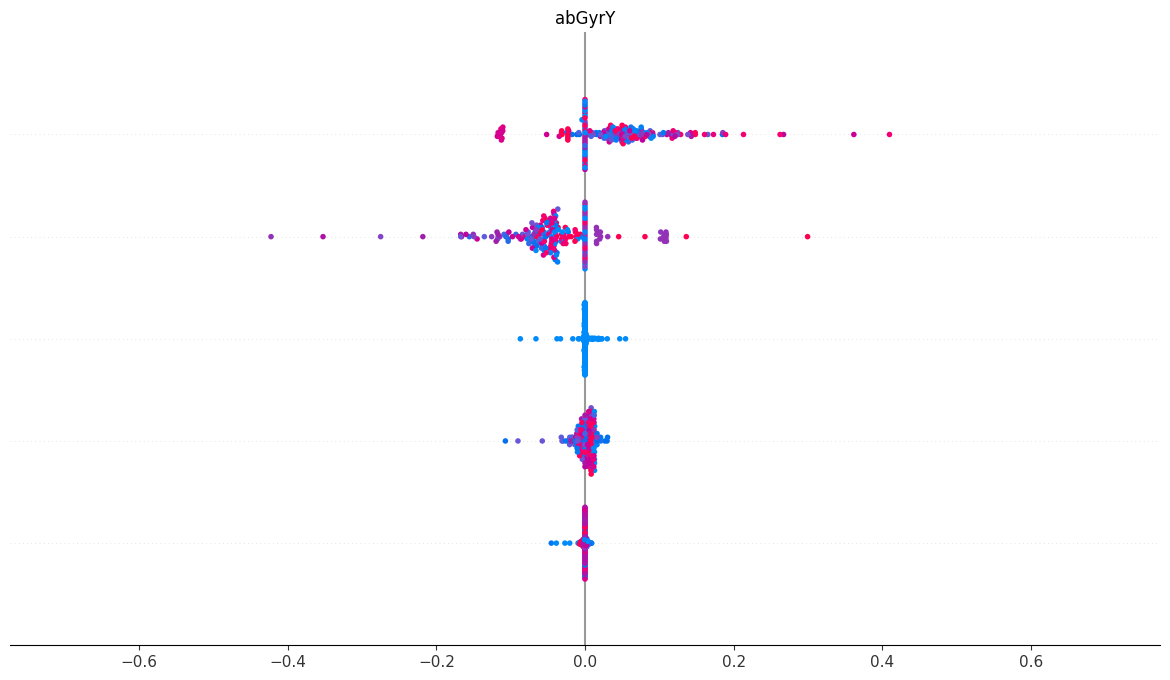

In [32]:
shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)


In [33]:
shap_values_kernel.shape

(200, 16, 5)

In [34]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 0  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")
    np.corrcoef(shap_values_kernel[:, feature_idx, :])

SHAP values for the first data point:
Feature 0: [0.03430622545727172, 0.07122026020745123, -0.04885861295421115, -0.08931548063219838, 0.03198141787337548]
Feature 1: [0.2664107366600741, 0.12495376108228848, -0.048855286704547606, -0.2973751299051754, -0.045800273335043176]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [-0.04112587714561014, 0.011694145308001128, -0.00024232000024194866, 0.030711674181676415, -0.0017038166476553624]
Feature 4: [0.0, 0.007791833962956673, 0.0, 0.0, 0.0]
Feature 5: [0.006942166474410039, 0.004570235085360185, 0.0, -0.011981088043145974, -0.00022738900813819296]
Feature 6: [0.09024995356968933, -0.052976844277829276, 0.0, -0.03007932710348125, -0.008135157893222994]
Feature 7: [0.02712962131273335, -0.013998421995433457, -0.00237156337949519, -0.008697901758346838, -0.002727926915222582]
Feature 8: [0.00862453394150216, -0.004501088485134788, -0.04885387058154205, 0.044471815693091145, -0.0004075859793010552]
Feature 9: [0.0, 0.0, 0.0, 0.0, 0.0]
Featu

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [35]:
np.corrcoef(shap_values_kernel[:, feature_idx, :])

array([[ 1.        , -0.92367198, -0.85850031, ..., -0.97076475,
         0.95521202,  0.99642378],
       [-0.92367198,  1.        ,  0.98824472, ...,  0.83497782,
        -0.787243  , -0.9042185 ],
       [-0.85850031,  0.98824472,  1.        , ...,  0.74299024,
        -0.68482259, -0.8320297 ],
       ...,
       [-0.97076475,  0.83497782,  0.74299024, ...,  1.        ,
        -0.99466387, -0.98560414],
       [ 0.95521202, -0.787243  , -0.68482259, ..., -0.99466387,
         1.        ,  0.97059606],
       [ 0.99642378, -0.9042185 , -0.8320297 , ..., -0.98560414,
         0.97059606,  1.        ]])

In [36]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 101  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [-0.27321631994879836, 0.198527154001498, -0.012334988298736605, -0.02292973201253925, 0.10985023891621624]
Feature 1: [0.15106566306205377, 0.16642731555600618, -0.052880771084704944, -0.09254239704925708, -0.17217345362345987]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [0.022862450441003903, -0.002755344606260257, 0.0005049726587784409, -0.023475899971572175, 0.0027601779347012994]
Feature 4: [0.023018412260533715, 0.0, 0.0, -0.022581850166932146, 0.0]
Feature 5: [0.013165050221236263, 0.009213242339982846, 0.0, -0.027749174542695727, 0.0052163832171950725]
Feature 6: [-0.09812994820947983, 0.21996839455784584, -0.016068235126787636, -0.10877606395016927, 0.0029022132375680454]
Feature 7: [-0.11819260207759932, 0.12981907195576595, -0.012288241658891646, 0.0, 0.0021145757710659616]
Feature 8: [0.03292482809870456, -0.018913414439330176, -0.052980196536613046, 0.03634143651154336, 0.002523701853745074]
Feature 9: [0.0, 0.0, 0.0, 0.

In [37]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 199  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [0.05865981599565567, -0.052113526590149624, -0.03733135143152817, 0.006612395759905021, 0.02481099704996246]
Feature 1: [-0.20200677713197696, -0.04623491327544655, -0.046709737711634114, 0.26675279956228026, 0.028836957660919732]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [-0.018625460201262167, -0.00301074135963081, -0.0008569936967498549, 0.046021016849437844, -0.022889493467887042]
Feature 4: [-0.058257505324455026, -0.008773904185004068, -0.043521586737761804, 0.14976567617416006, -0.03857435029317703]
Feature 5: [-0.09136111470670018, 0.0031913044880449745, 0.008139628408886433, 0.12551975678142133, -0.04485124716075115]
Feature 6: [-0.032397375731212194, -0.026751714970782114, -0.0002602905640198827, 0.07089381491898929, -0.010846108007000725]
Feature 7: [-0.02616911507963322, 0.00803010636078976, -0.005716348789324071, 0.013643006122914953, 0.010850677571161177]
Feature 8: [-0.02973236992196336, 0.015120243796502876, -0.047

In [38]:
import numpy as np
import pandas as pd

# Compute mean absolute SHAP values per feature for each class
shap_importance_per_class = np.mean(np.abs(shap_values_kernel), axis=0)  # Shape: (16, 5)

# Convert to DataFrame for better readability
shap_df = pd.DataFrame(shap_importance_per_class, columns=['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly'], index=feature_names)

# Display top contributing features for each anomaly type
for anomaly_class in shap_df.columns[1:]:  # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df[anomaly_class].sort_values(ascending=False))



Top Contributing Features for GPS Anomaly:
LineNo      0.095306
abTimeUS    0.086957
abT         0.070559
abAccX      0.061882
abAccY      0.028723
abAccZ      0.024848
abAHz       0.008990
abGHz       0.005589
abGyrY      0.005082
abGyrX      0.004045
abGyrZ      0.003327
abI         0.000000
abEA        0.000000
abEG        0.000000
abAH        0.000000
abGH        0.000000
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
abAccZ      0.072387
abTimeUS    0.064736
abT         0.054407
LineNo      0.046574
abAccY      0.016613
abAccX      0.010027
abAHz       0.003276
abGyrZ      0.002085
abGHz       0.002014
abGyrY      0.001740
abGyrX      0.000977
abI         0.000000
abEA        0.000000
abEG        0.000000
abAH        0.000000
abGH        0.000000
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
abTimeUS    0.134369
abT         0.083663
abAccX      0.062751
LineNo      0.047420
abAccZ      0.044353


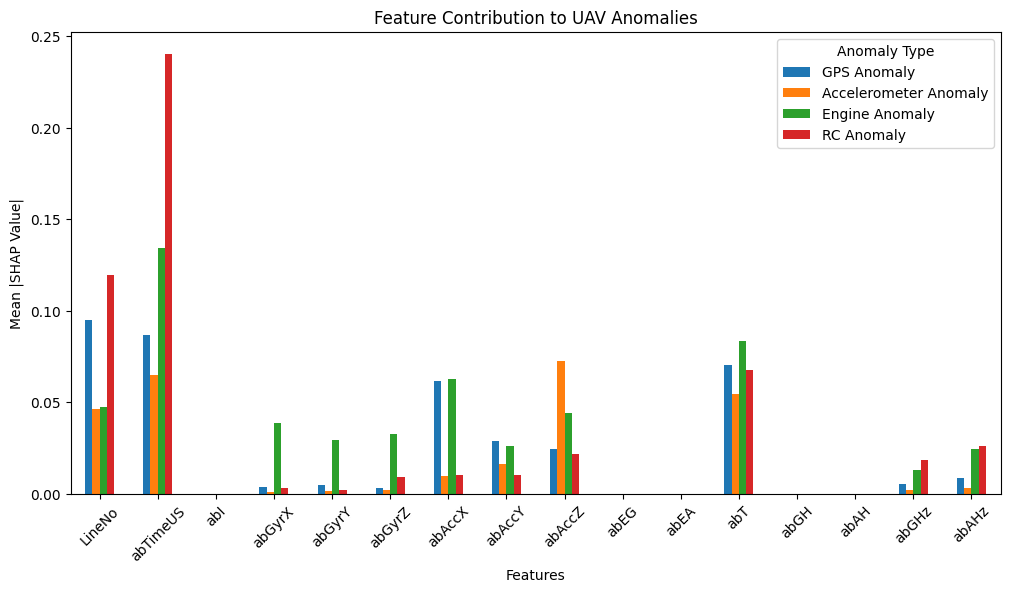

In [39]:
import matplotlib.pyplot as plt

# Plot feature importance for each anomaly type
shap_df.iloc[:, 1:].plot(kind='bar', figsize=(12, 6), title="Feature Contribution to UAV Anomalies")
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.legend(title="Anomaly Type")
plt.xticks(rotation=45)
plt.show()


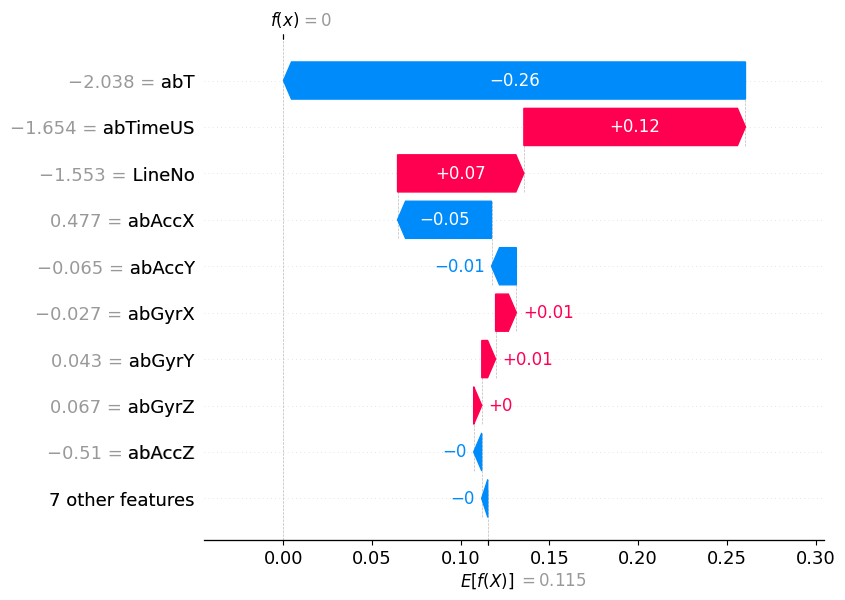

In [41]:
# prompt: plot waterfall graph for this SHaP

import matplotlib.pyplot as plt

# Assuming shap_values_kernel and feature_names are defined as in your provided code.

# Select a specific instance (example: index 0) and class to visualize (example: class 1)
instance_index = 0
class_index = 1

# Extract SHAP values for the selected instance and class
shap_values = shap_values_kernel[instance_index, :, class_index]

# Create the waterfall plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap.Explanation(values=shap_values,
                                      base_values=explainer_kernel.expected_value[class_index],
                                      data=X_test_sample[instance_index],
                                      feature_names=feature_names))
plt.show()
